In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

/opt/anaconda3/envs/yolo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
builder = tfds.builder("tf_flowers")
builder.download_and_prepare()
print(builder.info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/Users/odremanferrer/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [6]:
(raw_train, raw_validation, raw_test) = builder.as_dataset(split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True)

In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


2025-04-27 02:05:47.216572: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


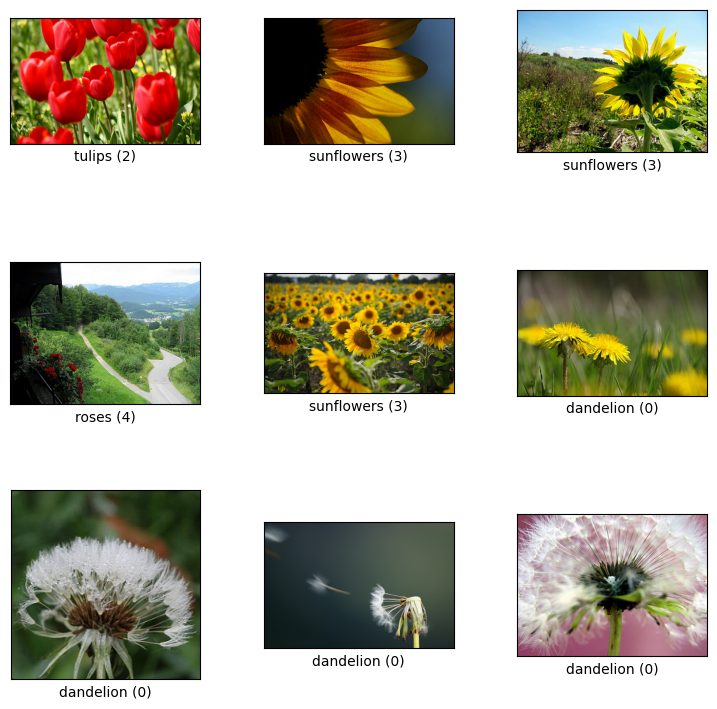

In [8]:
train_data = builder.as_dataset(split="train")
fig = tfds.show_examples(train_data, builder.info)

Show the first two images and labels from the training set:

In [9]:
IMG_SIZE = 150  # Todas las imágenes van a reescalarse a 100x100

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
])

In [10]:
num_classes = builder.info.features['label'].num_classes  # 5 Clases

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import InceptionV3

In [11]:
import tensorflow.keras.regularizers as regularizers

# Nuestro feature map de entrada es 150x150x3: 150x150 píxeles y 3 por los canales RGB
img_input = layers.Input(shape=(150, 150, 3))

x = layers.Conv2D(16, (3, 3), activation='relu')(img_input)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Flatten()(x)
x = layers.Dense(
    256,  # Menos neuronas para evitar sobreajuste
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)  # Regularización L2
)(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

In [12]:
# Configura y compila el modelo
model = Model(img_input, output)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,760,101 (18.16 MB)

 Trainable params: 4,760,101 (18.16 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # <-- ¡resize aquí!
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_batches = (raw_train
                 .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(1000)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

validation_batches = (raw_validation
                      .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      .prefetch(tf.data.AUTOTUNE))

test_batches = (raw_test
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Entrenamos el modelo
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=validation_batches,
                    callbacks=[early_stop]
                    )

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - acc: 0.3287 - loss: 3.3392 - val_acc: 0.5041 - val_loss: 1.2675
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - acc: 0.4579 - loss: 1.3468 - val_acc: 0.3515 - val_loss: 1.4921
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - acc: 0.5185 - loss: 1.2993 - val_acc: 0.5722 - val_loss: 1.1759
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - acc: 0.5429 - loss: 1.2342 - val_acc: 0.6158 - val_loss: 1.1808
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - acc: 0.5691 - loss: 1.1888 - val_acc: 0.4986 - val_loss: 1.2696
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - acc: 0.5999 - loss: 1.1769 - val_acc: 0.6213 - val_loss: 1.1160
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - acc: 0.6123 - loss: 1.1374 - val_acc: 0.6076 - val_loss: 1.1933
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - acc: 0.6395 - loss: 1.1088 - val_acc: 0.6294 - val_loss: 1.1841
Epoch 9/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - acc: 0.6372

Text(0.5, 1.0, 'Training and validation loss')

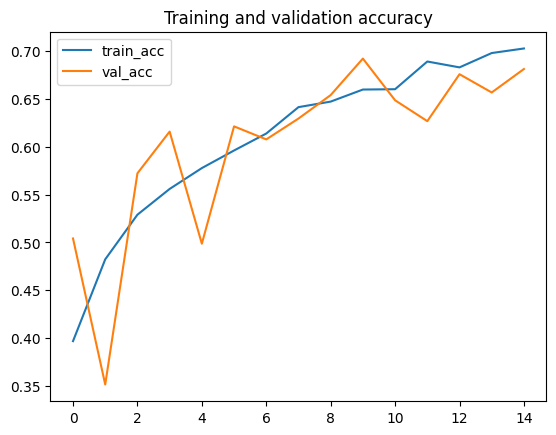

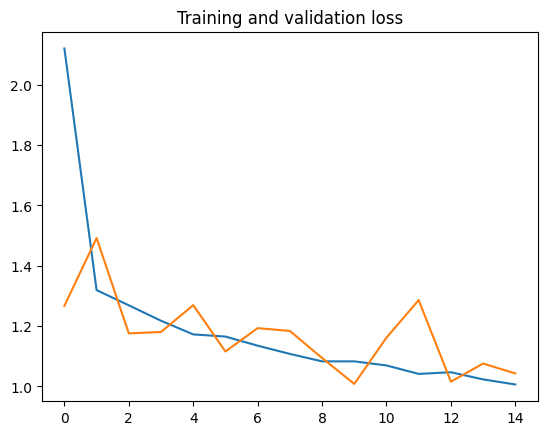

In [16]:
# Podemos extraer los valores de accuracy y loss del histórico que se ha guardado al entrenar la red
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Extraemos el número de épocas
epochs = range(len(acc))

# Representamos con plot nuestro accuracy por epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.figure()


# Representamos con plot nuestro loss por epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

### **[TODO] MEJORA EL MODELO USANDO INCEPTION V3**

In [26]:
# Descargar los pesos pre-entrenados de InceptionV3
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-04-27 03:05:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolviendo storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4003:803::201b, 2a00:1450:4003:80e::201b, 2a00:1450:4003:808::201b, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[2a00:1450:4003:803::201b]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 87910968 (84M) [application/x-hdf]
Grabando a: «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5»

/tmp/inception_v3_w 100%[===================>]  83.84M  13.8MB/s    en 6.4s    

2025-04-27 03:05:55 (13.1 MB/s) - «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5» guardado [87910968/87910968]



In [27]:
# Crear el modelo base de InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [28]:
# Congelar las capas pre-entrenadas
for layer in pre_trained_model.layers:
    layer.trainable = False

In [29]:
# Obtener la salida de la capa 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output


last layer output shape: (None, 7, 7, 768)


In [30]:
# Añadir las capas de clasificación
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.regularizers as regularizers

# Capa flatten para vectorizar el feature map
x = layers.Flatten()(last_output)
# Añadir una fully connected con 256 neuronas (como en tu modelo original)
x = layers.Dense(
    256,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)  # Mantener la regularización L2
)(x)
x = layers.Dropout(0.5)(x)  # Mantener el mismo dropout que en tu modelo
# Añadir la capa de salida con 5 clases
x = layers.Dense(num_classes, activation='softmax')(x)

# Configurar y compilar el modelo
model = Model(pre_trained_model.input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),  # Mantener el mismo learning rate
              metrics=['acc'])

In [31]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_475 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_475[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 35, 35,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_476 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_23… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_476[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_477 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_477[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 18,610,597 (70.99 MB)

 Trainable params: 9,635,333 (36.76 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [33]:
# Definir el data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
])

# Función de preprocesamiento que incluye data augmentation
def preprocess_with_augmentation(image, label):
    # Primero redimensionamos a un tamaño más grande para permitir el data augmentation
    image = tf.image.resize(image, (IMG_SIZE + 30, IMG_SIZE + 30))
    # Aplicamos data augmentation
    image = data_augmentation(image)
    # Finalmente redimensionamos al tamaño final
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Función de preprocesamiento sin data augmentation para validación
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Crear los batches con data augmentation para entrenamiento
train_batches = (raw_train
                 .map(preprocess_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(1000)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

# Crear los batches sin data augmentation para validación
validation_batches = (raw_validation
                      .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      .prefetch(tf.data.AUTOTUNE))

In [34]:
# Entrenar el modelo con las capas congeladas
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_batches,
    epochs=30,
    validation_data=validation_batches,
    callbacks=[early_stop]
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - acc: 0.4823 - loss: 6.2469 - val_acc: 0.6594 - val_loss: 1.4077
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - acc: 0.6586 - loss: 1.4896 - val_acc: 0.8365 - val_loss: 0.9809
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - acc: 0.7086 - loss: 1.3032 - val_acc: 0.8038 - val_loss: 1.0602
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - acc: 0.7090 - loss: 1.2666 - val_acc: 0.7057 - val_loss: 1.1734
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - acc: 0.7212 - loss: 1.2346 - val_acc: 0.7657 - val_loss: 1.0406
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - acc: 0.7018 - loss: 1.2529 - val_acc: 0.7984 - val_loss: 0.9588
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - acc: 0.7117 - loss: 1.2182 - val_acc: 0.8283 - val_loss: 0.9460
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - acc: 0.6973 - loss: 1.2220 - val_acc: 0.7520 - val_loss: 1.0928
Epoch 9/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/

In [35]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_475 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_475[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 35, 35,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_476 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_23… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_476[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_477 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_477[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 28,245,932 (107.75 MB)

 Trainable params: 9,635,333 (36.76 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

 Optimizer params: 9,635,335 (36.76 MB)

In [36]:
# Fine-tuning: Descongelar las capas superiores de InceptionV3
unfreeze = False
for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True

# Recompilar el modelo con un learning rate más bajo
from tensorflow.keras.optimizers import SGD
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(learning_rate=0.00001, momentum=0.9),
              metrics=['acc'])

In [37]:
# Continuar el entrenamiento
history_fine = model.fit(
    train_batches,
    epochs=50,
    validation_data=validation_batches,
    callbacks=[early_stop]
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - acc: 0.7009 - loss: 1.3100 - val_acc: 0.7738 - val_loss: 1.0369
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - acc: 0.6989 - loss: 1.2977 - val_acc: 0.7684 - val_loss: 1.0811
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - acc: 0.7102 - loss: 1.3076 - val_acc: 0.7657 - val_loss: 1.0957
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - acc: 0.7154 - loss: 1.2719 - val_acc: 0.7684 - val_loss: 1.0968
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - acc: 0.7234 - loss: 1.2685 - val_acc: 0.7684 - val_loss: 1.0928
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - acc: 0.7094 - loss: 1.2706 - val_acc: 0.7684 - val_loss: 1.0888


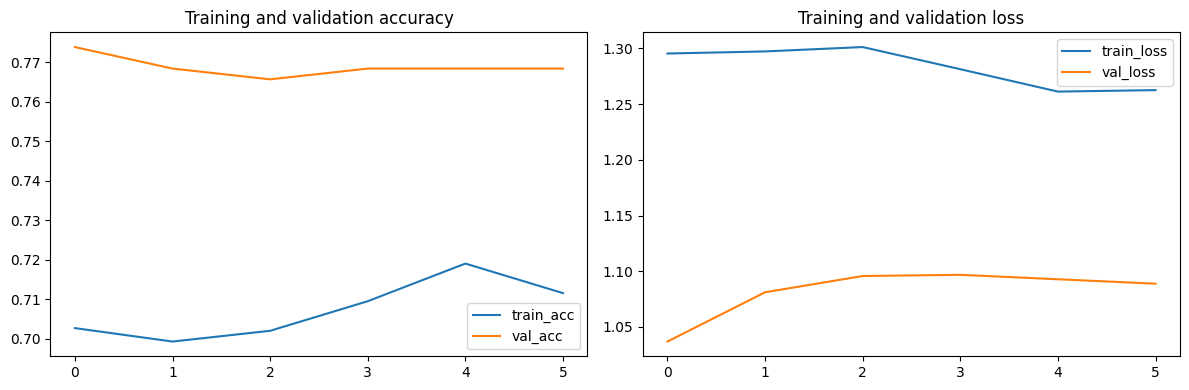

In [38]:
# Visualizar los resultados
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()